In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import QTable

import rayven as rv
# print(dir(rv))
# print(rv.__path__)

# Simulating a star in the center of the FoV

In [2]:
fstar = 1e12

## make a star of flux 1e12 counts 
bsc_tab = QTable(data=[[0], [0], [fstar], [-2.5*np.log10(fstar)+30]], 
                 names=['ra', 'dec', 'flux', 'mag'])

## place the star at the center of the FoV (fa_x, fa_y) = 0. fa_x, fa_y are field angles in radians.
transf_tab = QTable(data=[[0], [0], [0], [0]], 
                    names=['ra', 'dec', 'fa_x', 'fa_y'])

## set all the reflectances to be 2%
reflectance = rv.Reflectance(fil=0.02, det=0.02, L3=0.02, L2=0.02, L1=0.02, band='r')

## initialize a GhostTool object with (ra, dec, band, zeropoint) that do not really matter here,
## bright star catalog with the made-up star, 
## coordinate transform table with the location of the star on the FoV,
## reflectances of the optics of the telescope (2%)
gt = rv.GhostTool(
    ra=0, dec=0, band='r', zeropoint=30,
    reflectance=reflectance,
    bright_star_table=bsc_tab, 
    coord_transform_table=transf_tab
)

In [3]:
field_ghost_set = gt.batoid_simulator.simulate_fov()

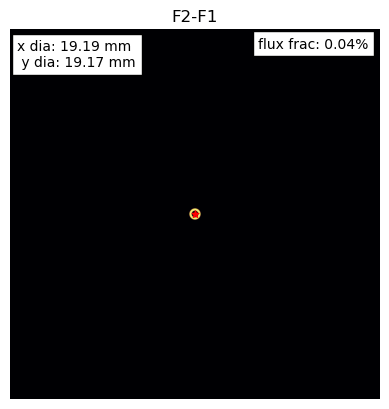

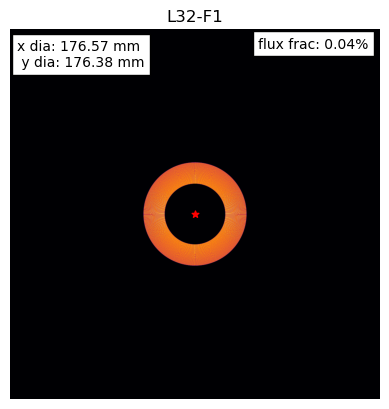

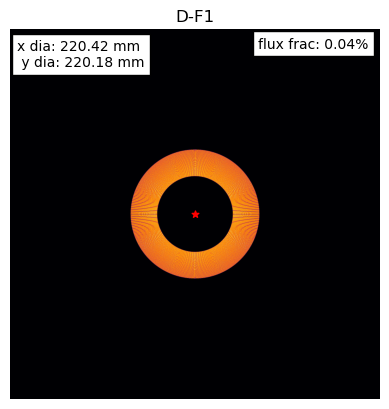

In [4]:
f_g = []
for ghost in field_ghost_set[0].ghosts:

    ## 10 brightest ghosts
    if ghost.name in ['F2-F1', 'L32-F1', 'L32-F2', 'L31-F1', 'L31-F2',
                      'L32-L31', 'D-F1', 'D-F2', 'D-L32', 'D-L31']:

        ## get flux of each ghost
        f_g.append(np.sum(ghost.flux))

        ## visualization
        if ghost.name in ['F2-F1', 'L32-F1', 'D-F1']:
            fig, ax = plt.subplots()

            ax.imshow(ghost.bin(1000), cmap='inferno')
            ax.scatter(499, 499, marker='*', c='r', s=25)
            ax.set_title(ghost.name)
            ax.text(0.02, 0.9, f'x dia: {ghost.x_size:.2f} mm \n y dia: {ghost.y_size:.2f} mm',
                    transform=ax.transAxes, bbox=dict(facecolor='white'))
    
            ax.text(0.97, 0.95, f'flux frac: {100*np.sum(ghost.flux)/field_ghost_set[0].total_flux:.2f}%',
                    ha='right', transform=ax.transAxes, bbox=dict(facecolor='white'))
            ax.set_axis_off()

## Using least squares to solve for the reflectances

We are solving the matrix equation:

$$ M \log{\vec{r}} = \log{\vec{\frac{f_g}{f_*}}}$$

Here, $\vec{r}$ contains the reflectances that we want to solve for:
\begin{bmatrix}
R_{\rm F1} \\
R_{\rm F2} \\
R_{\rm L32} \\
R_{\rm L31}\\
R_{\rm D}
\end{bmatrix}

and $\vec{f_g}$ contains the fluxes of the ghosts:
\begin{bmatrix}
f_{\rm F2-F1} \\
f_{\rm L32-F1} \\
f_{\rm L32-F2} \\
f_{\rm L31-F1}\\
f_{\rm L31-F2} \\
f_{\rm L32-L31} \\
f_{\rm D-F1} \\
f_{\rm D-F2} \\
f_{\rm D-L31} \\
f_{\rm D-L32} 
\end{bmatrix}

In [5]:
log_fg_by_fstar = np.log(np.array(f_g)/fstar)
M = np.array([[1, 1, 0, 0, 0],
              [1, 0, 1, 0, 0],
              [0, 1, 1, 0, 0],
              [1, 0, 0, 1, 0],
              [0, 1, 0, 1, 0],
              [0, 0, 1, 1, 0],
              [1, 0, 0, 0, 1], 
              [0, 1, 0, 0, 1], 
              [0, 0, 0, 1, 1],
              [0, 0, 1, 0, 1]])

In [6]:
r, residuals, rank, s = np.linalg.lstsq(M, log_fg_by_fstar, rcond=-1)
print(f'The estimated reflectances are:')

for i, label in enumerate(['F1', 'F2', 'L32', 'L31', 'D']):
    print(f'{label:<4}: {100*np.exp(r[i]):.2f}%')

The estimated reflectances are:
F1  : 1.90%
F2  : 1.98%
L32 : 1.98%
L31 : 2.00%
D   : 1.90%


# Simulating a star at the edge of the FoV

In [7]:
fstar = 1e12

bsc_tab = QTable(data=[[0], [0], [fstar], [-2.5*np.log10(fstar)+30]], 
                 names=['ra', 'dec', 'flux', 'mag'])

transf_tab = QTable(data=[[0], [0], [-0.032], [0]],  # 0.03 rad ~ 1.83 deg off the boresight
                    names=['ra', 'dec', 'fa_x', 'fa_y'])

reflectance = rv.Reflectance(fil=0.02, det=0.02, L3=0.02, L2=0.02, L1=0.02, band='r')

gt = rv.GhostTool(
    ra=0, dec=0, band='r', zeropoint=30,
    reflectance=reflectance,
    bright_star_table=bsc_tab, 
    coord_transform_table=transf_tab
)

field_ghost_set = gt.batoid_simulator.simulate_fov()

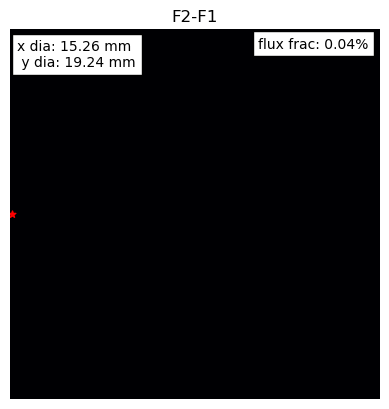

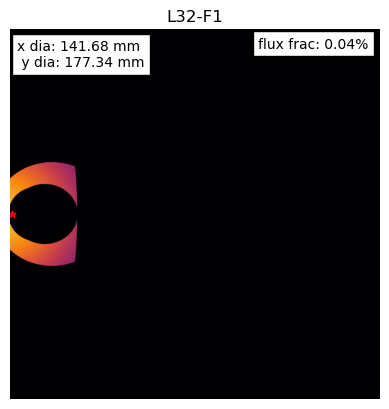

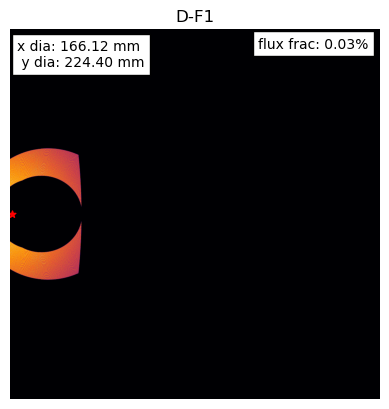

In [8]:
f_g = []
for ghost in field_ghost_set[0].ghosts:
    if ghost.name in ['F2-F1', 'L32-F1', 'L32-F2', 'L31-F1', 'L31-F2',
                      'L32-L31', 'D-F1', 'D-F2', 'D-L32', 'D-L31']:
        f_g.append(np.sum(ghost.flux))

        ## visualization
        if ghost.name in ['F2-F1', 'L32-F1', 'D-F1']:
            fig, ax = plt.subplots()

            ax.imshow(ghost.bin(1000), cmap='inferno')
            #ax.scatter(0, 499, marker='*', c='r', s=25)
            ax.set_title(ghost.name)
            ax.text(0.02, 0.9, f'x dia: {ghost.x_size:.2f} mm \n y dia: {ghost.y_size:.2f} mm',
                    transform=ax.transAxes, bbox=dict(facecolor='white'))
    
            ax.text(0.97, 0.95, f'flux frac: {100*np.sum(ghost.flux)/field_ghost_set[0].total_flux:.2f}%',
                    ha='right', transform=ax.transAxes, bbox=dict(facecolor='white'))
            ax.set_axis_off()

In [9]:
log_fg_by_fstar = np.log(np.array(f_g)/fstar)
r, residuals, rank, s = np.linalg.lstsq(M, log_fg_by_fstar, rcond=-1)

print(f'The estimated reflectances are:')

for i, label in enumerate(['F1', 'F2', 'L32', 'L31', 'D']):
    print(f'{label:<4}: {100*np.exp(r[i]):.2f}%')

The estimated reflectances are:
F1  : 1.65%
F2  : 1.83%
L32 : 2.21%
L31 : 1.48%
D   : 2.07%


# Using reflectances from syseng_throughputs

In [10]:
fstar = 1e12

bsc_tab = QTable(data=[[0], [0], [fstar], [-2.5*np.log10(fstar)+30]], 
                 names=['ra', 'dec', 'flux', 'mag'])

transf_tab = QTable(data=[[0], [0], [0], [0]], 
                    names=['ra', 'dec', 'fa_x', 'fa_y'])

gt = rv.GhostTool(
    ra=0, dec=0, band='r', zeropoint=30,
    bright_star_table=bsc_tab, 
    coord_transform_table=transf_tab
)

field_ghost_set = gt.batoid_simulator.simulate_fov()

In [11]:
f_g = []
for ghost in field_ghost_set[0].ghosts:

    if ghost.name in ['F2-F1', 'L32-F1', 'L32-F2', 'L31-F1', 'L31-F2',
                      'L32-L31', 'D-F1', 'D-F2', 'D-L32', 'D-L31']:

        f_g.append(np.sum(ghost.flux))

In [12]:
log_fg_by_fstar = np.log(np.array(f_g)/fstar)
r, residuals, rank, s = np.linalg.lstsq(M, log_fg_by_fstar, rcond=-1)

print(f'optical elt.| estimated | actual')

for i, (label, key) in enumerate(zip(['F1', 'F2', 'L32', 'L31', 'D'], 
                                 ['r_entrance', 'r_exit', 'L3_exit', 'L3_entrance', 'E2V'])):
    print(f'{label:<12}| {100*np.exp(r[i]):>6.2f}%   | {100*gt.reflectance.values[key]:.2f}%')

optical elt.| estimated | actual
F1          |   3.18%   | 3.46%
F2          |   3.41%   | 3.46%
L32         |   2.64%   | 2.69%
L31         |   2.69%   | 2.69%
D           |   2.72%   | 2.93%
